# 1. データの取得  
ダウンロードしたipynbファイルとcsvファイルを自分のGoogleドライブに置く。

## 1-1. csvファイルを利用する場合


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('drive/My Drive/RNNによる為替予測/USDJPY_1.csv')
df

,datetime,open,high,low,close,volume
0,2005-05-07T21:00:00.000000000Z,105.145,105.165,105.075,105.125,254
1,2005-05-08T21:00:00.000000000Z,105.135,105.686,105.095,105.628,34018
2,2005-05-09T21:00:00.000000000Z,105.628,105.966,105.390,105.560,34363
3,2005-05-10T21:00:00.000000000Z,105.550,105.946,104.886,105.760,36765
4,2005-05-11T21:00:00.000000000Z,105.760,106.914,105.710,106.776,32469
...,...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,114.650,115.489,114.476,115.362,85666
4996,2022-01-27T22:00:00.000000000Z,115.358,115.688,115.122,115.238,73707
4997,2022-01-30T22:00:00.000000000Z,115.296,115.592,114.923,115.136,70090
4998,2022-01-31T22:00:00.000000000Z,115.110,115.195,114.566,114.688,68569


## 1-2. AlphavantageAPIを使用する場合

In [ ]:
!pip install alpha_vantage
!pip install alpha_vantage pandas

In [ ]:
# 5分毎の
url = 'https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=5min&apikey=demo'

In [ ]:
# 必要なjsonのみ取得する
import requests

def get_json(url, category):
    r = requests.get(url)
    data = r.json()
    data = data[category]
    return data

# 5分毎のドル円相場と1日ごとのドル円相場をそれぞれ取得する
data = get_json(url, 'Time Series FX (5min)')

In [ ]:
import pandas as pd

def json_to_df(data):
  df = pd.DataFrame(data)
  df = df.T
  df.columns = ['open', 'high', 'low', 'close']

  df = df.sort_index(ascending=True)

  df = df.reset_index()
  df['datatime'] = df['index']
  df['open'] = df['open'].astype(float, errors = 'raise')
  df['high'] = df['high'].astype(float, errors = 'raise')
  df['low'] = df['low'].astype(float, errors = 'raise')
  df['close'] = df['close'].astype(float, errors = 'raise')

  df = df[['datatime', 'open', 'high', 'low', 'close']]
  return df

df = json_to_df(data)
df

,datatime,open,high,low,close
0,2022-02-18 13:40:00,1.13556,1.13590,1.1352,1.13584
1,2022-02-18 13:45:00,1.13580,1.13615,1.1355,1.13582
2,2022-02-18 13:50:00,1.13583,1.13590,1.1349,1.13547
3,2022-02-18 13:55:00,1.13545,1.13556,1.1349,1.13538
4,2022-02-18 14:00:00,1.13539,1.13549,1.1345,1.13490
...,...,...,...,...,...
95,2022-02-18 21:35:00,1.13275,1.13295,1.1325,1.13279
96,2022-02-18 21:40:00,1.13284,1.13287,1.1323,1.13240
97,2022-02-18 21:45:00,1.13264,1.13273,1.1322,1.13258
98,2022-02-18 21:50:00,1.13256,1.13262,1.1321,1.13237


# 2. データの加工
今回は特に処理をしない。

# 3. データを可視化・相関の確認

In [ ]:
data = df['close']

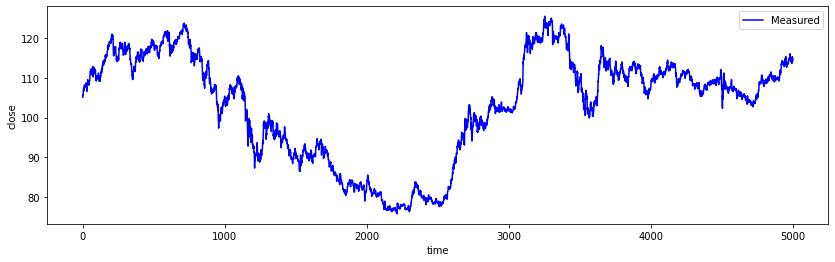

In [ ]:
# データの可視化
import matplotlib.pyplot as plt

def show_graph(df, data ,label='close', color="b"):
    X_index = df.index.values
    X = data.values
    plt.figure(figsize=(14, 4))
    plt.xlabel('time')
    plt.ylabel(label)
    plt.plot(X_index, X, color=color, label='Measured')
    plt.legend(loc='upper right')
    plt.show()

show_graph(df, data, 'close')

# 4. スケーリング

In [ ]:
# 正規化
from sklearn.preprocessing import MinMaxScaler

def Normalization(data):
    data = pd.DataFrame(data)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)
    return scaler, data

In [ ]:
# 一応標準化のためのライブラリも掲載。実行しなくてよい。

# from sklearn.preprocessing import StandardScaler

# def Standalization(data):
#   data = pd.DataFrame(data)
#   scaler = StandardScaler()
#   data = scaler.fit_transform(data)
#   return scaler, data

# scaler, data = Standalization(df['EMA_close'])

# 5. 訓練データと検証データとテストデータに分割

In [ ]:
def split_train_valid_test(data):
    train, valid, test = data[0:int(len(data)*0.7),:], data[int(len(data)*0.7):int(len(data)*0.9),:], data[int(len(data)*0.9):,:]
    return train, valid, test

# 6. モデルの検証

In [ ]:
# モデルのインポート
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf

In [ ]:
# ハイパラメータ
window = 50
horizon = 1
epoch_size = 100
batch_size=1
output = 5
units = 20
learning_rate = 0.001
optimizer = 'adam'
activation = 'tanh'
loss = 'mean_squared_error'

In [ ]:
# モデルが学習できるようにデータを加工
def create_dataset(dataset, window, output):
    dataX, dataY = [], []
    for i in range(len(dataset)-window-output+1):
        xset, yset = [], []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+window), j]
            xset.append(a)

        b = dataset[(i+window):(i+window)+output]
        yset.append(b)
        dataX.append(xset)
        dataY.append(yset)
    return np.array(dataX), np.array(dataY).reshape(len(dataY),output)

def arrange_dataset(df, datalist, window, horizon, output):
    trainlist = []
    validlist = []
    testlist = []
    for i in range(horizon):
      scaler, data = Normalization(df[datalist[i]])
      train, valid, test = split_train_valid_test(data)
      trainX, trainY = create_dataset(train, window, output)
      validX, validY = create_dataset(valid, window, output)
      testX, testY = create_dataset(test, window, output)

      trainlist.append(trainX)
      validlist.append(validX)
      testlist.append(testX)

      if i == 0:
        real_trainY = trainY
        real_validY = validY
        real_testY = testY
        real_scaler = scaler        
        real_data = data

    trainX = np.concatenate(trainlist, axis=1)
    validX = np.concatenate(validlist, axis=1)
    testX = np.concatenate(testlist, axis=1)
    return trainX, real_trainY, validX, real_validY, testX, real_testY, real_scaler, real_data

trainX, trainY, validX, validY, testX, testY, scaler,data = arrange_dataset(df, ['close'], window, horizon, output)

In [ ]:
# モデル1
def create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss):
    model = keras.models.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=(horizon, window)),
        keras.layers.LSTM(units),
        keras.layers.Dense(output, activation=activation)
      ])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
model = create_model(horizon, window, output, units, learning_rate, optimizer, activation, loss)

In [ ]:
# モデルの学習
def learning_model(trainX, trainY, validX, validY, model, epoch_size):
  history = model.fit(trainX, trainY, epochs=epoch_size, validation_data=(validX, validY))
  return history

history = learning_model(trainX, trainY, validX, validY, model, epoch_size)

Epoch 1/50
108/108 [==============================] - 4s 12ms/step - loss: 0.1285 - val_loss: 0.0232
Epoch 2/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0131 - val_loss: 0.0069
Epoch 3/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 4/50
108/108 [==============================] - 1s 6ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 5/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 6/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 7/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 8/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 9/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 0.002

# 7. モデルの性能評価

In [ ]:
import math
from sklearn.metrics import mean_squared_error

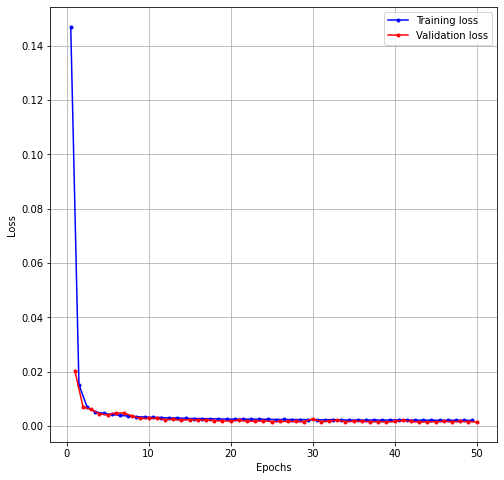

In [ ]:
# 各エポック毎の訓練誤差とテスト誤差を可視化。

def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [ ]:
# testX, testY = create_dataset(test, look_back, output)

def pad_array(val, pad_col):
    # 以下のnp.insertは配列pad_colのインデックス0番目の位置にxを挿入するという意味
    return np.array([np.insert(pad_col, 0, x) for x in val])

def reshape_dataset(dataset):
    dataset = dataset.reshape(len(dataset), -1)
    return dataset


def print_mse(model, trainX, trainY, validX, validY, testX, testY, data, scaler=True):
    # 10個前過去のデータ～1個前のデータまでを入力データとし、予測値を求める    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    pad_col = np.zeros(data.shape[1]-1)

    # 標準化したデータを元に戻す
    if scaler == True:
      trainPredict = scaler.inverse_transform(pad_array(trainPredict, pad_col))
      trainY = scaler.inverse_transform(pad_array(trainY, pad_col))
      validPredict = scaler.inverse_transform(pad_array(validPredict, pad_col))
      validY = scaler.inverse_transform(pad_array(validY, pad_col))
      testPredict = scaler.inverse_transform(pad_array(testPredict, pad_col))
      testY = scaler.inverse_transform(pad_array(testY, pad_col))
    else:
      trainPredict = reshape_dataset(trainPredict)
      trainY = reshape_dataset(trainY)
      validPredict = reshape_dataset(validPredict)
      validY = reshape_dataset(validY)
      testPredict = reshape_dataset(testPredict)
      testY = reshape_dataset(testY)
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    validScore = math.sqrt(mean_squared_error(validY[:,0], validPredict[:,0]))
    print('Valid Score: %.2f RMSE' % (validScore))
    testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    return trainPredict, validPredict, testPredict

trainPredict, validPredict, testPredict = print_mse(model, trainX, trainY, validX, validY, testX, testY, data, scaler)

Train Score: 0.03 RMSE
Valid Score: 0.02 RMSE
Test Score: 0.02 RMSE
